In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 12,5
import warnings
warnings.filterwarnings('ignore')

In [2]:
money = pd.read_csv('../Data/M2SLMoneyStock.csv', index_col=0, parse_dates=True)

In [3]:
money.index.freq = 'MS'

In [4]:
spending = pd.read_csv('../Data/PCEPersonalSpending.csv', index_col=0, parse_dates=True)

In [5]:
spending.index.freq = 'MS'

In [6]:
df = money.join(spending)

In [7]:
df.head()

,Money,Spending
Date,,
1995-01-01,3492.4,4851.2
1995-02-01,3489.9,4850.8
1995-03-01,3491.1,4885.4
1995-04-01,3499.2,4890.2
1995-05-01,3524.2,4933.1


In [8]:
df.tail()

,Money,Spending
Date,,
2015-08-01,12096.8,12394.0
2015-09-01,12153.8,12392.8
2015-10-01,12187.7,12416.1
2015-11-01,12277.4,12450.1
2015-12-01,12335.9,12469.1


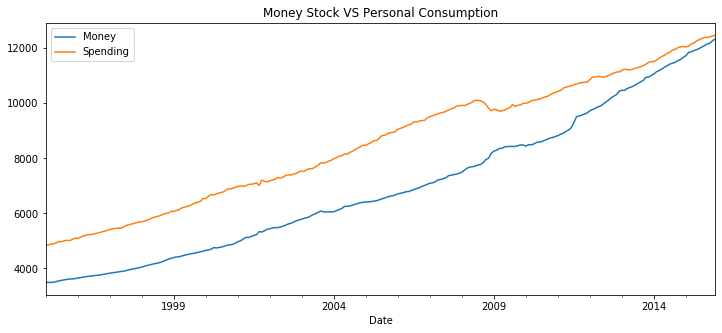

In [9]:
df.plot(title='Money Stock VS Personal Consumption')
plt.legend();

# Stationarity Test

In [10]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [11]:
for i in df.columns:
    print(adf_test(df[i], i))
    print()

Augmented Dickey-Fuller Test: Money
ADF test statistic        4.239022
p-value                   1.000000
# lags used               4.000000
# observations          247.000000
critical value (1%)      -3.457105
critical value (5%)      -2.873314
critical value (10%)     -2.573044
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary
None

Augmented Dickey-Fuller Test: Spending
ADF test statistic        0.149796
p-value                   0.969301
# lags used               3.000000
# observations          248.000000
critical value (1%)      -3.456996
critical value (5%)      -2.873266
critical value (10%)     -2.573019
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary
None



In [12]:
from pmdarima import auto_arima

In [13]:
# auto_arima(df['Money'], maxiter=1000)
# auto_arima(df['Spending'], maxiter=1000)

In [14]:
from statsmodels.tsa.statespace.tools import diff

In [15]:
transformed_df = diff(df[['Money', 'Spending']], k_diff=1)

In [16]:
for i in df.columns:
    print(adf_test(transformed_df[i], i))
    print()

Augmented Dickey-Fuller Test: Money
ADF test statistic       -2.057404
p-value                   0.261984
# lags used              15.000000
# observations          235.000000
critical value (1%)      -3.458487
critical value (5%)      -2.873919
critical value (10%)     -2.573367
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary
None

Augmented Dickey-Fuller Test: Spending
ADF test statistic     -7.226974e+00
p-value                 2.041027e-10
# lags used             2.000000e+00
# observations          2.480000e+02
critical value (1%)    -3.456996e+00
critical value (5%)    -2.873266e+00
critical value (10%)   -2.573019e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
None



In [17]:
transformed_df = diff(df[['Money', 'Spending']], k_diff=2)

In [18]:
for i in df.columns:
    print(adf_test(transformed_df[i], i))
    print()

Augmented Dickey-Fuller Test: Money
ADF test statistic     -7.077471e+00
p-value                 4.760675e-10
# lags used             1.400000e+01
# observations          2.350000e+02
critical value (1%)    -3.458487e+00
critical value (5%)    -2.873919e+00
critical value (10%)   -2.573367e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
None

Augmented Dickey-Fuller Test: Spending
ADF test statistic     -8.760145e+00
p-value                 2.687900e-14
# lags used             8.000000e+00
# observations          2.410000e+02
critical value (1%)    -3.457779e+00
critical value (5%)    -2.873609e+00
critical value (10%)   -2.573202e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
None



In [19]:
transformed_df.head()

,Money,Spending
Date,,
1995-03-01,3.7,35.0
1995-04-01,6.9,-29.8
1995-05-01,16.9,38.1
1995-06-01,-0.3,1.5
1995-07-01,-6.2,-51.7


In [20]:
len(transformed_df)

250

In [21]:
# TRAIN TEST SPLIT

In [22]:
nob = 12

In [23]:
train = transformed_df.iloc[:-nob]

In [24]:
test = transformed_df.iloc[-nob:]

In [25]:
# VAR p selection

In [26]:
from statsmodels.tsa.api import VARMAX

In [27]:
# MODEL

In [28]:
model = VARMAX(train, order=(1,2), trend='c')

In [29]:
result = model.fit(maxiter=1000, disp=False)
result.summary()

Dep. Variable:,"['Money', 'Spending']",No. Observations:,238
Model:,"VARMA(1,2)",Log Likelihood,-2286.151
,+ intercept,AIC,4606.303
Date:,"Sat, 04 Jul 2020",BIC,4665.331
Time:,20:31:24,HQIC,4630.092
Sample:,03-01-1995,,
,- 12-01-2014,,
Covariance Type:,opg,,
Ljung-Box (Q):,"67.82, 27.95",Jarque-Bera (JB):,"566.08, 127.11"
Prob(Q):,"0.00, 0.92",Prob(JB):,"0.00, 0.00"
Heteroskedasticity (H):,"5.69, 2.90",Skew:,"1.35, -0.35"


In [30]:
predictions = result.forecast(steps=12)

In [31]:
predictions

,Money,Spending
2015-01-01,-12.585986,38.015380
2015-02-01,-11.012522,-5.995164
2015-03-01,1.667994,0.098221
2015-04-01,-1.597160,-0.565184
2015-05-01,1.069720,0.338882
2015-06-01,-0.378108,-0.106255
2015-07-01,0.500006,0.172388
2015-08-01,-0.015102,0.010405
2015-09-01,0.290031,0.106617
2015-10-01,0.109801,0.049833


In [32]:
test

,Money,Spending
Date,,
2015-01-01,-15.5,-26.6
2015-02-01,56.1,52.4
2015-03-01,-102.8,39.5
2015-04-01,30.9,-40.4
2015-05-01,-15.8,38.8
2015-06-01,14.0,-34.1
2015-07-01,6.7,6.9
2015-08-01,-0.7,-8.5
2015-09-01,5.5,-39.8


In [33]:
# Inverse diff

In [34]:
predictions['Money_1d'] = (df['Money'].iloc[-nob-1]-df['Money'].iloc[-nob-2]) + predictions['Money'].cumsum()

predictions['Moneyforecast'] = (df['Money'].iloc[-nob-1]) + predictions['Money_1d'].cumsum()

In [35]:
predictions['Spending_1d'] = (df['Spending'].iloc[-nob-1]-df['Spending'].iloc[-nob-2]) + predictions['Spending'].cumsum()

predictions['Spendingforecast'] = (df['Spending'].iloc[-nob-1]) + predictions['Spending_1d'].cumsum()

In [36]:
predictions

,Money,Spending,Money_1d,Moneyforecast,Spending_1d,Spendingforecast
2015-01-01,-12.585986,38.015380,66.014014,11736.114014,48.615380,12110.615380
2015-02-01,-11.012522,-5.995164,55.001492,11791.115506,42.620216,12153.235595
2015-03-01,1.667994,0.098221,56.669486,11847.784992,42.718437,12195.954032
2015-04-01,-1.597160,-0.565184,55.072326,11902.857318,42.153252,12238.107284
2015-05-01,1.069720,0.338882,56.142046,11958.999365,42.492135,12280.599419
2015-06-01,-0.378108,-0.106255,55.763938,12014.763303,42.385880,12322.985299
2015-07-01,0.500006,0.172388,56.263945,12071.027248,42.558268,12365.543567
2015-08-01,-0.015102,0.010405,56.248843,12127.276090,42.568673,12408.112240
2015-09-01,0.290031,0.106617,56.538874,12183.814964,42.675290,12450.787530
2015-10-01,0.109801,0.049833,56.648675,12240.463639,42.725123,12493.512653


In [37]:
# Plot results

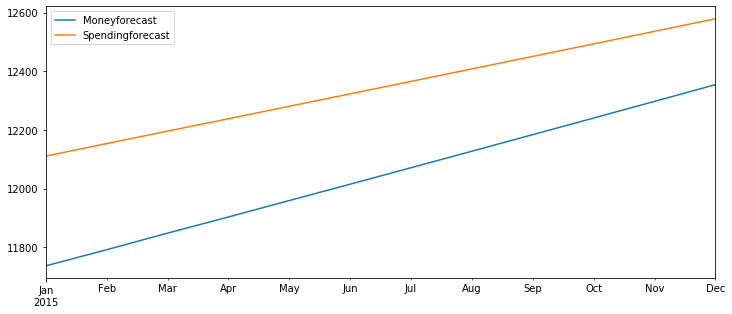

In [38]:
predictions[['Moneyforecast', 'Spendingforecast']].plot();

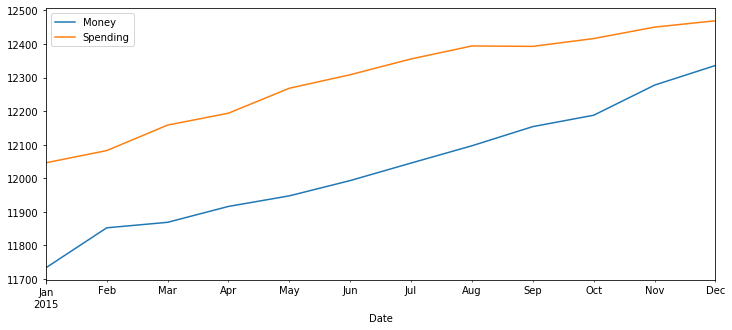

In [39]:
df.iloc[-12:].plot();

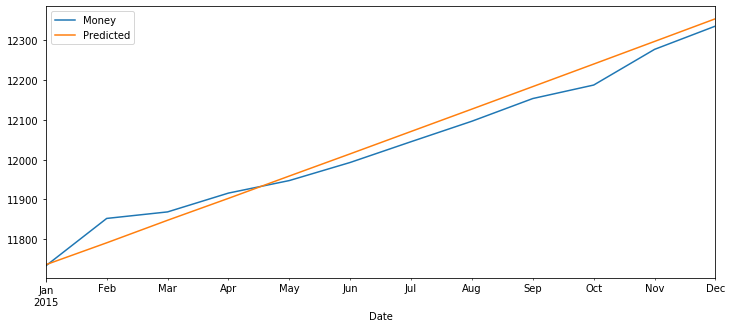

In [40]:
df.iloc[-12:]['Money'].plot()
predictions['Moneyforecast'].plot(label='Predicted')
plt.legend()
plt.show()

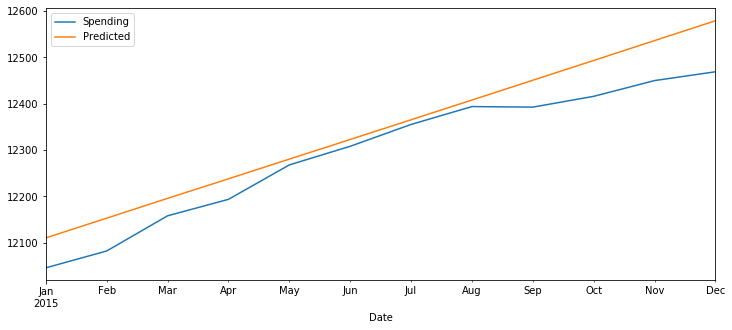

In [41]:
df.iloc[-12:]['Spending'].plot()
predictions['Spendingforecast'].plot(label='Predicted')
plt.legend()
plt.show()

In [42]:
from statsmodels.tools.eval_measures import rmse

In [63]:
for i in df.columns:
    print('VARMA ' + i + ': {}\n'.format(rmse(df[i].iloc[-12:], predictions[i+'forecast'])))

VARMA Money: 30.267629109769384

VARMA Spending: 59.271710476504886



# ARMA Model

In [44]:
money.head()

,Money
Date,
1995-01-01,3492.4
1995-02-01,3489.9
1995-03-01,3491.1
1995-04-01,3499.2
1995-05-01,3524.2


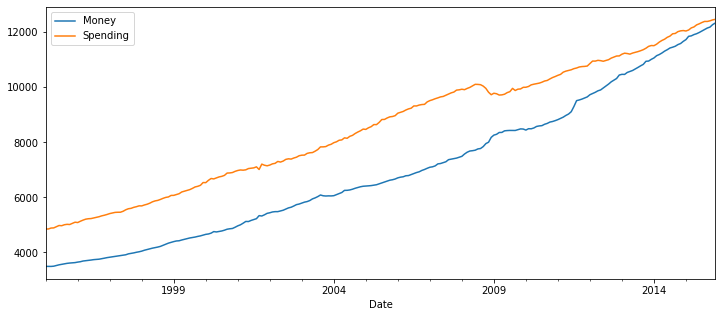

In [45]:
money['Money'].plot()
spending['Spending'].plot()
plt.legend();

# Model for Money

In [46]:
auto_arima(money['Money'],seasonal=False)

ARIMA(callback=None, disp=0, maxiter=None, method=None, order=(1, 2, 2),
      out_of_sample_size=0, scoring='mse', scoring_args={}, seasonal_order=None,
      solver='lbfgs', start_params=None, suppress_warnings=False,
      transparams=True, trend=None, with_intercept=True)

In [47]:
test_m = money.iloc[-nob:]
train_m = money.iloc[:-nob]

In [48]:
print('Training Dataset length : {}'.format(len(train_m)))
print('Testing Dataset length : {}'.format(len(test_m)))

Training Dataset length : 240
Testing Dataset length : 12


In [49]:
from statsmodels.tsa.arima_model import ARIMA

In [50]:
model = ARIMA(train_m, order=(1,2,2)).fit()

In [51]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D2.Money   No. Observations:                  238
Model:                 ARIMA(1, 2, 2)   Log Likelihood               -1117.710
Method:                       css-mle   S.D. of innovations             26.215
Date:                Sat, 04 Jul 2020   AIC                           2245.421
Time:                        20:31:27   BIC                           2262.782
Sample:                    03-01-1995   HQIC                          2252.418
                         - 12-01-2014                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.1814      0.029      6.302      0.000       0.125       0.238
ar.L1.D2.Money    -0.3569      0.293     -1.217      0.223      -0.931       0.218
ma.L1.D2.Money    -0.4087      0.260     -1.572      0.116      -0.918       0.101
ma.L2.D2.Money    -0.5912      0.260     -2.278      0.023      -1.100      -0.083
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.8023           +0.0000j            2.8023            0.5000
MA.1            1.0000           +0.0000j            1.0000            0.0000
MA.2           -1.6913           +0.0000j            1.6913            0.5000
-----------------------------------------------------------------------------
"""

In [52]:
pred_m = model.predict(start = len(train_m), end=len(train_m) + len(test_m)-1, typ='levels', dynamic=False).rename('ARIMA Money Predictions')

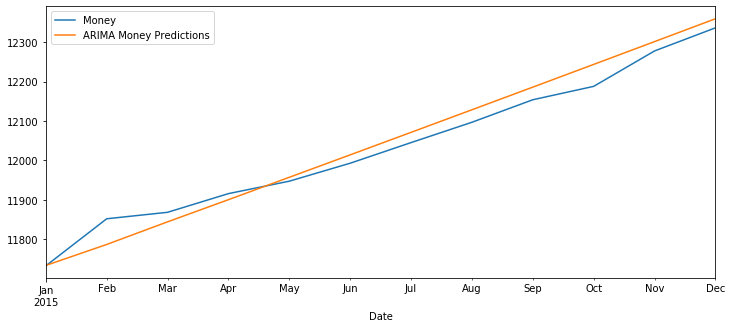

In [53]:
test_m.plot()
pred_m.plot()
plt.legend();

In [54]:
from statsmodels.tools.eval_measures import rmse

In [55]:
print('ARMA model RMSE : {}'.format(rmse(test_m['Money'], pred_m)))
print('VARMA model RMSE : {}'.format(rmse(test_m['Money'], predictions['Moneyforecast'])))


ARMA model RMSE : 32.236688335926935
VARMA model RMSE : 30.267629109769384


# Model for spending

In [56]:
auto_arima(spending['Spending'],seasonal=False)

ARIMA(callback=None, disp=0, maxiter=None, method=None, order=(1, 1, 2),
      out_of_sample_size=0, scoring='mse', scoring_args={}, seasonal_order=None,
      solver='lbfgs', start_params=None, suppress_warnings=False,
      transparams=True, trend=None, with_intercept=True)

In [57]:
test_s = spending.iloc[-nob:]
train_s = spending.iloc[:-nob]

In [58]:
print('Training Dataset length : {}'.format(len(train_s)))

print('Testing Dataset length : {}'.format(len(test_s)))

Training Dataset length : 240
Testing Dataset length : 12


In [59]:
model = ARIMA(train_s, order=(1,1,2)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:             D.Spending   No. Observations:                  239
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -1181.357
Method:                       css-mle   S.D. of innovations             33.910
Date:                Sat, 04 Jul 2020   AIC                           2372.714
Time:                        20:31:30   BIC                           2390.097
Sample:                    02-01-1995   HQIC                          2379.719
                         - 12-01-2014                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               30.1074      3.463      8.694      0.000      23.320      36.894
ar.L1.D.Spending     0.7864      0.153      5.142      0.000       0.487       1.086
ma.L1.D.Spending    -0.8096      0.160     -5.068      0.000      -1.123      -0.496
ma.L2.D.Spending     0.1499      0.071      2.104      0.035       0.010       0.289
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2717           +0.0000j            1.2717            0.0000
MA.1            1.9119           +0.0000j            1.9119            0.0000
MA.2            3.4897           +0.0000j            3.4897            0.0000
-----------------------------------------------------------------------------
"""

In [60]:
pred_s = model.predict(start = len(train_s), end=len(train_s) + len(test_s)-1, typ='levels', dynamic=False).rename('ARIMA Spending Predictions')

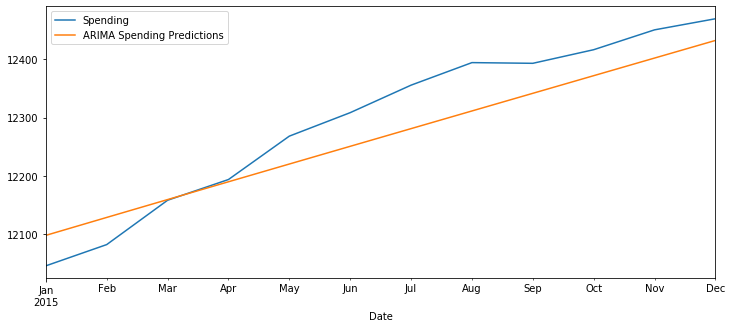

In [61]:
test_s.plot()
pred_s.plot()
plt.legend();

In [62]:
print('ARMA model RMSE : {}'.format(rmse(test_s['Spending'], pred_s)))
print('VARMA model RMSE : {}'.format(rmse(test_s['Spending'], predictions['Spendingforecast'])))


ARMA model RMSE : 51.01187081385231
VARMA model RMSE : 59.271710476504886
